In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 200

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the encoder part of the VAE
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mean = nn.Linear(hidden_dim, z_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, z_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        z_mean = self.fc2_mean(h)
        z_logvar = self.fc2_logvar(h)
        return z_mean, z_logvar

# Define the decoder part of the VAE
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        x_recon = torch.sigmoid(self.fc2(h))
        return x_recon

# Define the Autoencoder part of the VAE
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        x_recon = torch.sigmoid(self.fc2(h))
        return x_recon

# Define the Autodecoder part of the VAE
class Autodecoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, output_dim):
        super(Autodecoder, self).__init__()
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        x_recon = torch.sigmoid(self.fc2(h))
        return x_recon

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, z_dim)
        self.decoder = Decoder(z_dim, hidden_dim, input_dim)
        self.autoencoder = Autoencoder(input_dim, hidden_dim)
        self.autodecoder = Autodecoder(z_dim, hidden_dim, input_dim)

    def reparameterize(self, z_mean, z_logvar):
        std = torch.exp(0.5 * z_logvar)
        eps = torch.randn_like(std)
        return z_mean + eps * std

    def forward(self, x):
        z_mean, z_logvar = self.encoder(x)
        z = self.reparameterize(z_mean, z_logvar)
        x_recon = self.decoder(z)
        x_auto_recon = self.autoencoder(x)
        x_auto_decoded = self.autodecoder(z)
        return x_recon, x_auto_recon, x_auto_decoded, z_mean, z_logvar

# Define the loss function for VAE
def vae_loss(x, x_recon, x_auto_recon, x_auto_decoded, z_mean, z_logvar):
    recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')
    auto_recon_loss = F.binary_cross_entropy(x_auto_recon, x, reduction='sum')
    auto_decoded_loss = F.binary_cross_entropy(x_auto_decoded, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    return recon_loss + auto_recon_loss + auto_decoded_loss + kl_div

In [11]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:11<00:00, 874691.48it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 95666.65it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:06<00:00, 243043.02it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [13]:
# Hyperparameters
input_dim = 28 * 28
hidden_dim = 400
z_dim = 20
num_epochs = 10
learning_rate = 0.001

# Model, optimizer, and loss function
model = VAE(input_dim, hidden_dim, z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
model.train()
train_loss = []
for epoch in range(num_epochs):
    epoch_loss = 0
    for x, _ in tqdm(train_loader):
        x = x.view(-1, input_dim).to(device)
        optimizer.zero_grad()
        x_recon, x_auto_recon, x_auto_decoded, z_mean, z_logvar = model(x)
        loss = vae_loss(x, x_recon, x_auto_recon, x_auto_decoded, z_mean, z_logvar)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_loss.append(epoch_loss / len(train_loader.dataset))
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss / len(train_loader.dataset):.4f}')


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:10<00:00, 89.93it/s]


Epoch 1, Loss: 360.8566


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 93.97it/s]


Epoch 2, Loss: 258.8520


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:11<00:00, 84.91it/s]


Epoch 3, Loss: 246.8588


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:10<00:00, 90.86it/s]


Epoch 4, Loss: 241.6280


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:10<00:00, 89.04it/s]


Epoch 5, Loss: 238.5650


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 95.32it/s]


Epoch 6, Loss: 236.4278


100%|███████████████████████████████████████████████████████████████████████████████| 938/938 [00:08<00:00, 104.64it/s]


Epoch 7, Loss: 234.9182


100%|███████████████████████████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 100.41it/s]


Epoch 8, Loss: 233.8393


100%|████████████████████████████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 99.48it/s]


Epoch 9, Loss: 232.8474


100%|███████████████████████████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 103.81it/s]


Epoch 10, Loss: 232.1117


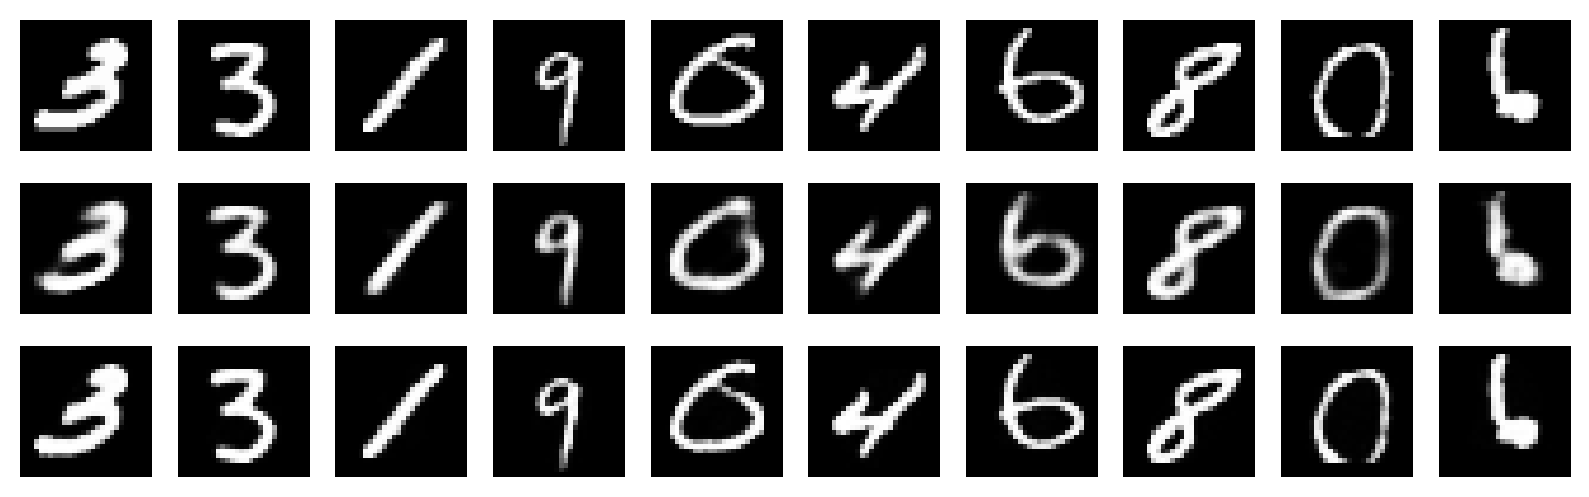

In [15]:
def plot_reconstructed_images(model, n=10):
    model.eval()
    with torch.no_grad():
        x, _ = next(iter(train_loader))
        x = x.view(-1, input_dim).to(device)
        x_recon, x_auto_recon, x_auto_decoded, _, _ = model(x)
        x = x.cpu().numpy()
        x_recon = x_recon.cpu().numpy()
        x_auto_recon = x_auto_recon.cpu().numpy()
        x_auto_decoded = x_auto_decoded.cpu().numpy()

        fig, axes = plt.subplots(3, n, figsize=(10, 3))
        for i in range(n):
            axes[0, i].imshow(x[i].reshape(28, 28), cmap='gray')
            axes[1, i].imshow(x_recon[i].reshape(28, 28), cmap='gray')
            axes[2, i].imshow(x_auto_recon[i].reshape(28, 28), cmap='gray')
            axes[0, i].axis('off')
            axes[1, i].axis('off')
            axes[2, i].axis('off')
        plt.show()

plot_reconstructed_images(model)
